In [1]:
import kagglehub

try:
    # Attempt to download the latest version of the dataset
    path = kagglehub.dataset_download("ziqiangg/nuimages")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Download failed: {e}")
    print("You might need to set up Kaggle API credentials.")

Using Colab cache for faster access to the 'nuimages' dataset.
Path to dataset files: /kaggle/input/nuimages


In [2]:
import os

# Define paths based on kagglehub cache location
KAGGLE_CACHE_ROOT = "/root/.cache/kaggle/input/nuimages"
PROJ_ROOT = KAGGLE_CACHE_ROOT  # We'll use the cache root as the project root
META_DIR  = f"{PROJ_ROOT}"
DATA_DIR  = f"{PROJ_ROOT}"
CROPS_DIR = f"{DATA_DIR}/crops/crops"  # Based on your path: /root/.../crops/crops

print("Data location for training:", CROPS_DIR)
print("Data size:")
!du -sh "$CROPS_DIR"

Data location for training: /root/.cache/kaggle/input/nuimages/crops/crops
Data size:
3.3G	/root/.cache/kaggle/input/nuimages/crops/crops


In [42]:
import pandas as pd
import numpy as np
import json, random
from PIL import Image, ImageOps, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms, models
import itertools

import matplotlib.pyplot as plt

#training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

#gradCAM
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from collections import defaultdict
import torch.nn.functional as F

#metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, f1_score
import seaborn as sns

#tsne feature space plot
from sklearn.manifold import TSNE

#local
MANIFEST_PATH   = f"{META_DIR}/manifest.csv"
CLASSES_JSON    = f"{META_DIR}/classes.json"

SEED = 42


In [4]:
def seed_everything(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Deterministic kernels (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # If you need *strict* determinism (may error on some ops):
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Make each worker deterministic (NumPy / Python RNG too)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

seed_everything(SEED)

In [6]:
with open(CLASSES_JSON, "r") as f:
    classes_meta = json.load(f)

# Expecting a "classes" list with fields: id, name, display_name, ...
name_to_id = {c["name"]: c["id"] for c in classes_meta["classes"]}
id_to_name = {c["id"]: c["name"] for c in classes_meta["classes"]}
index_order = classes_meta.get("index_order", [c["name"] for c in classes_meta["classes"]])

print("Classes (name -> id):", name_to_id)

Classes (name -> id): {'car': 0, 'truck': 1, 'bus': 2, 'trailer': 3, 'construction_vehicle': 4, 'pedestrian': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic_cone': 8, 'barrier': 9}


In [7]:
df = pd.read_csv(MANIFEST_PATH)

IOU_THR = 0.60
IOA_THR = 0.60

clean_df = df.query("max_cross_iou < @IOU_THR and max_cross_ioa < @IOA_THR").reset_index(drop=True)

print("Kept rows:", len(clean_df), "of", len(df), " | -", len(df)-len(clean_df))
print(clean_df["class"].value_counts(dropna=False))


Kept rows: 163739 of 172178  | - 8439
class
car                     81346
barrier                 18540
truck                   16709
pedestrian              15299
traffic_cone             8172
bicycle                  7110
motorcycle               7101
bus                      3628
construction_vehicle     3601
trailer                  2233
Name: count, dtype: int64


In [8]:
# Majority (primary) class per image, to stratify at image level
img_class_counts = (clean_df.groupby(["img_path","class"])
                    .size().reset_index(name="n"))
major = (img_class_counts.sort_values(["img_path","n"], ascending=[True, False])
                      .drop_duplicates("img_path"))
img2label = dict(zip(major["img_path"], major["class"]))

groups = clean_df["img_path"].values
y_img  = clean_df["img_path"].map(img2label).values

def stratified_group_split70_15_15(df, y=None, groups=None, seed=42):
    """
    Leak-proof 70/15/15 split:
      - one row per unique img_path (primary/majority class per image)
      - stratify on image-level primary class
      - map image splits back to crop rows
    """
    # 1) Image-level table with primary label
    img_tab = (df.groupby(['img_path','class'])
                 .size().reset_index(name='n')
                 .sort_values(['img_path','n'], ascending=[True, False])
                 .drop_duplicates('img_path'))
    imgs = img_tab['img_path'].values
    yimg = img_tab['class'].values

    # 2) Train 70% vs Temp 30% (stratified by image primary class)
    imgs_train, imgs_temp, y_train, y_temp = train_test_split(
        imgs, yimg, train_size=0.70, random_state=seed, stratify=yimg
    )

    # 3) Temp → Val/Test 50/50 (≈15/15 overall), stratified
    imgs_val, imgs_test, y_val, y_test = train_test_split(
        imgs_temp, y_temp, train_size=0.50, random_state=seed, stratify=y_temp
    )

    # 4) Map back to crop rows
    s_train, s_val, s_test = set(imgs_train), set(imgs_val), set(imgs_test)
    train_df = df[df['img_path'].isin(s_train)].reset_index(drop=True)
    val_df   = df[df['img_path'].isin(s_val)].reset_index(drop=True)
    test_df  = df[df['img_path'].isin(s_test)].reset_index(drop=True)

    # 5) Sanity: zero leakage
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    assert len(a & b) == 0 and len(a & c) == 0 and len(b & c) == 0, "Leakage across splits!"

    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_group_split70_15_15(clean_df, y_img, groups, seed=SEED)

def _summary(df, name):
    print(f"{name:5s} rows={len(df):6d}  images={df['img_path'].nunique():5d}")
    print(df["class"].value_counts(dropna=False),"\n")

def leakage_ok(train_df, val_df, test_df):
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    print("train∩val:", len(a & b), "  train∩test:", len(a & c), "  val∩test:", len(b & c))

_summary(train_df, "train")
_summary(val_df,   "val")
_summary(test_df,  "test")
leakage_ok(train_df, val_df, test_df)  # should all be 0


train rows=114965  images=39745
class
car                     57174
barrier                 12921
truck                   11722
pedestrian              10868
traffic_cone             5715
motorcycle               4998
bicycle                  4987
bus                      2535
construction_vehicle     2506
trailer                  1539
Name: count, dtype: int64 

val   rows= 24335  images= 8517
class
car                     12012
barrier                  2843
truck                    2479
pedestrian               2203
traffic_cone             1240
bicycle                  1051
motorcycle               1051
construction_vehicle      562
bus                       561
trailer                   333
Name: count, dtype: int64 

test  rows= 24439  images= 8517
class
car                     12160
barrier                  2776
truck                    2508
pedestrian               2228
traffic_cone             1217
bicycle                  1072
motorcycle               1052
construction_vehicle

In [9]:
def attach_abs_paths(df):
    """Optimized path resolution to local storage"""
    def resolve(p):
        p = str(p).strip().lstrip("./")
        # Already absolute -> keep
        if os.path.isabs(p) or p.startswith("/content/drive"):
            return os.path.normpath(p)
        # Manifest stored "data/crops/..."
        if p.startswith("data/crops/"):
            rel = p.split("data/", 1)[1]          # -> "crops/..."
            return os.path.normpath(os.path.join(DATA_DIR, rel))
        # Manifest stored "crops/..."
        if p.startswith("crops/"):
            rel = p.split("crops/", 1)[1]         # -> e.g. "traffic_cone/xxx.jpg"
            return os.path.normpath(os.path.join(CROPS_DIR, rel))
        # Default: treat relative to LOCAL_CROPS_DIR
        return os.path.normpath(os.path.join(CROPS_DIR, p))

    out = df.copy()
    out["__abs_path__"] = out["crop_path"].apply(resolve)
    mask = out["__abs_path__"].apply(os.path.exists)
    missing = int((~mask).sum())
    if missing:
        print(f"[warn] {missing} crop files resolved to non-existent paths (filtered out).")
    return out[mask].reset_index(drop=True)

class Letterbox224:
    """
    Resize preserving aspect ratio and pad to 224x224.
    - Uses high-quality BICUBIC upsampling for small crops.
    - Pads with black (0) by default (works fine with ImageNet normalization later).
    """
    def __init__(self, size=224, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if w == 0 or h == 0:
            # create a dummy black image to avoid crashes
            return Image.new("RGB", (self.size, self.size), self.fill)

        scale = min(self.size / w, self.size / h)  # fit within square
        nw, nh = max(1, int(round(w * scale))), max(1, int(round(h * scale)))
        # Resize with antialiasing (BICUBIC is good for upscaling small crops)
        img = img.resize((nw, nh), Image.BICUBIC)

        # pad to square canvas
        new_im = Image.new("RGB", (self.size, self.size), self.fill)
        left = (self.size - nw) // 2
        top  = (self.size - nh) // 2
        new_im.paste(img, (left, top))
        return new_im

def collate_skip_none(batch):
    """Drop samples that failed to load/transform."""
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    xs, ys = zip(*batch)
    return torch.stack(xs, 0), torch.tensor(ys)

In [10]:
train_df_ = attach_abs_paths(train_df)
val_df_   = attach_abs_paths(val_df)
test_df_  = attach_abs_paths(test_df)

letterbox = Letterbox224(224, fill=0)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    letterbox,
    # ADDED BY ROBIN
    transforms.RandomHorizontalFlip(p=0.5),      # Horizontal flip 0.5
    transforms.RandomVerticalFlip(p=0.5),        # Vertical flip 0.5
    transforms.RandomRotation(degrees=36),       # Rotate 0.2 * 180 = 36 degrees
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Random zoom 0.2 (0.8 to 1.2x)
    # END
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    letterbox,
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [11]:
class NuCropsDataset(Dataset):
    def __init__(self, frame, label_map, transform, report_small=True, small_thresh=12):
        self.df = frame.reset_index(drop=True)
        self.lm = label_map
        self.t = transform
        self.report_small = report_small
        self.small_thresh = small_thresh
        self._small_seen = 0

        # Pre-compute all labels to avoid dictionary lookup during training
        self.labels = [self.lm[r["class"]] for _, r in self.df.iterrows()]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        # Direct access instead of df.iloc[i] which is slow
        path = self.df.iloc[i]["__abs_path__"]
        y = self.labels[i]  # Pre-computed, no lookup needed

        try:
            with Image.open(path) as im:
                im = im.convert("RGB")
                if self.report_small:
                    w, h = im.size
                    if w < self.small_thresh or h < self.small_thresh:
                        self._small_seen += 1
                x = self.t(im) if self.t else im
        except Exception as e:
            # Skip unreadable images without crashing the batch
            return None
        return x, y

train_ds = NuCropsDataset(train_df_, label_map=name_to_id, transform=train_tfms)
val_ds   = NuCropsDataset(val_df_,   label_map=name_to_id, transform=eval_tfms, report_small=False)
test_ds  = NuCropsDataset(test_df_,  label_map=name_to_id, transform=eval_tfms, report_small=False)

In [12]:
BATCH = 24
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,                 # reproducible because we seed + pass generator
    num_workers=8,
    pin_memory=False,
    collate_fn=collate_skip_none,
    worker_init_fn=seed_worker,
    generator=g,                  # <-- important
    persistent_workers=False,     # keep False for simplest determinism
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False, num_workers=8,
    pin_memory=False, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH, shuffle=False, num_workers=8,
    pin_memory=False, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

# Quick peek
batch = next(iter(train_loader))
if batch is None:
    print("[warn] first batch was empty after skipping Nones — try again or check data.")
else:
    xb, yb = batch
    print("train batch:", tuple(xb.shape), tuple(yb.shape))  # e.g., (24, 3, 224, 224)

train batch: (24, 3, 224, 224) (24,)


# Loss Function Comparison Study
Implementing and comparing Focal Loss, Cross-Entropy Loss, and Weighted Cross-Entropy Loss on a unified ResNet architecture for improved class imbalance handling.

---

## Data Augmentation Pipeline
* **Horizontal flip** = 0.5
* **Vertical flip** = 0.5
* **Rotation** = 0.2 * 180 = 36 degrees
* **Random zoom** = 0.2 (0.8 to 1.2x)
* **Mean Normalization**

---

## Model Architecture Specification
**Input tensor:** (24, 3, 224, 224)  
**Output:** 10 classes (multiclass classification)

### Feature Extractor:
1. **Initial Conv Layer:**
   * 3 input channels (RGB), 64 output channels
   * Kernel size=7x7, Stride=2, Padding=3
   * Batch Normalization
   * ReLU Activation Function

2. **Residual Blocks** (3 blocks total, each with 2 convolutions + batchnorm + ReLU on residual sum):
   * **Block 1:** 64 in_channels, 64 out_channels, kernel size=3x3, stride=1
   * **Block 2:** 64 in_channels, 128 out_channels, kernel size=3x3, stride=2
   * **Block 3:** 128 in_channels, 256 out_channels, kernel size=3x3, stride=1
   * **Global Average Pooling** (output: 256-dimensional vector)

### Classifier:
3. **Fully Connected Layers:**
   * **FC 1:** Input=256, Output=512, ReLU Activation, Dropout=0.3
   * **FC 2:** Input=512, Output=10 (raw logits - no SoftMax applied in model)

---

## Experimental Setup

### Model Variants:
**Model A - Focal Loss ResNet:**
* **Loss Function:** Focal Loss
  * Formula: `FL(p_t) = -α_t * (1 - p_t)^γ * log(p_t)`
  * Hyperparameters: γ (gamma) = 2.0, α (alpha) = 0.25
  * Output: Raw logits (no SoftMax in forward pass)

**Model B - Cross-Entropy Loss ResNet:**
* **Loss Function:** Cross-Entropy Loss (`nn.CrossEntropyLoss`)
* **Output:** Raw logits (SoftMax handled internally by loss function)
* **Note:** No class weighting applied

**Model C - Weighted Cross-Entropy Loss ResNet:**
* **Loss Function:** Weighted Cross-Entropy Loss (`nn.CrossEntropyLoss` with class weights)
* **Class weights:** Calculated based on inverse frequency of each class in training set
  * `weight_c = total_samples / (num_classes * samples_in_class_c)`
* **Output:** Raw logits (SoftMax handled internally by loss function)

### Training Configuration (Shared across all models):
1. **Optimizer:** Adam with learning rate = 0.001
2. **Learning Rate Scheduler:** ReduceLROnPlateau
   * Mode: 'min' (minimize validation loss)
   * Patience: 3 epochs
   * Factor: 0.5 (reduce LR by half when no improvement)
3. **Early Stopping:** Monitor validation loss with patience = 7 epochs
4. **Batch Size:** 24 (as per input tensor specification)
5. **Epochs:** Maximum 40 epochs (or early stopping triggered)
6. **Validation Split:** 20% of training data

### Training Protocol:
1. **Data Preparation:**
   * Calculate class distribution for weighted CE loss
   * Apply identical data augmentation pipeline to all models
   * Ensure reproducible splits using fixed random seed

2. **Model Training:**
   * Train each model variant independently using identical data splits
   * Use same random initialization seeds for fair comparison
   * Monitor training and validation loss/accuracy per epoch

3. **Evaluation Metrics:**
   * **Primary:** Validation accuracy
   * **Secondary:** Per-metric class table
   * **Class imbalance metrics:**  Confusion matrix analysis
   * **Loss convergence:** Training/validation loss curves comparison



In [17]:
# Define the ResNet-like model architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()

        # Initial Conv Layer: 3 -> 64 channels, 7x7 kernel, stride 2, padding 3
        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks
        self.block1 = ResidualBlock(64, 64, stride=1)  # 64 -> 64
        self.block2 = ResidualBlock(64, 128, stride=2)  # 64 -> 128
        self.block3 = ResidualBlock(128, 256, stride=1)  # 128 -> 256

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.fc1 = nn.Linear(256, 512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)  # Output raw logits (no SoftMax)

    def forward(self, x):
        # Initial conv layer
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.maxpool(x)

        # Residual blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Classifier
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # Raw logits (no SoftMax)

        return x


# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute probabilities
        pt = torch.exp(-ce_loss)

        # Compute focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


def calculate_class_weights(train_df, name_to_id):
    """Calculate class weights based on inverse frequency"""
    class_counts = train_df['class'].value_counts()
    total_samples = len(train_df)
    num_classes = len(name_to_id)

    # Create weight tensor
    weights = torch.zeros(num_classes)
    for class_name, count in class_counts.items():
        class_idx = name_to_id[class_name]
        weight = total_samples / (num_classes * count)
        weights[class_idx] = weight

    return weights

def get_current_lr(optimizer):
    """Get current learning rate from optimizer"""
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss_fn, loss_name, num_epochs=20, patience=7, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model = model.to(device)

    # Print header
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<10} {'Val Loss':<12} {'Val Acc':<10} {'LR':<10}")
    print("-" * 70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Show tqdm only for batches with minimal output
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}',
                                                        leave=False, bar_format='{l_bar}{bar:10}{r_bar}')):
            if data is None:
                continue
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                if data is None:
                    continue
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += loss_fn(output, target).item()

                _, predicted = output.max(1)
                val_total += target.size(0)
                val_correct += predicted.eq(target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        current_lr = get_current_lr(optimizer)

        # Print epoch results in table format
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<9.2f}% {val_loss:<12.4f} {val_acc:<9.2f}% {current_lr:<10.6f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch+1}')
                break

    # Load best model and save it
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

        # Create models directory if it doesn't exist
        models_dir = "models"
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)

        # Save the best model
        model_path = os.path.join(models_dir, f"best_model_{loss_name}.pth")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, model_path)
        print(f"\nBest model saved to {model_path}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            if data is None:
                continue
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

In [15]:
#experiment setup
# Calculate class weights for weighted CE
class_weights = calculate_class_weights(train_df, name_to_id)
print("Class weights:", class_weights)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training configurations
num_classes = len(name_to_id)
results = {}

Class weights: tensor([0.2011, 0.9808, 4.5351, 7.4701, 4.5876, 1.0578, 2.3002, 2.3053, 2.0116,
        0.8898])
Using device: cuda


In [18]:
# Model A: Focal Loss
print("\n" + "="*70)
print("Training Model A: Focal Loss")
print("="*70)
model_a = SimpleResNet(num_classes=num_classes)
focal_loss = FocalLoss(alpha=0.25, gamma=2.0)
model_a, train_losses_a, val_losses_a, train_accs_a, val_accs_a = train_model(
    model_a, train_loader, val_loader, focal_loss, "focal_loss", device=device
)
preds_a, targets_a = evaluate_model(model_a, test_loader, device=device)
results['focal_loss'] = {
    'model': model_a,
    'train_losses': train_losses_a,
    'val_losses': val_losses_a,
    'train_accs': train_accs_a,
    'val_accs': val_accs_a,
    'test_preds': preds_a,
    'test_targets': targets_a
}


Training Model A: Focal Loss
Epoch  Train Loss   Train Acc  Val Loss     Val Acc    LR        
----------------------------------------------------------------------


1      0.1446       70.27    % 0.1378       70.88    % 0.001000  


2      0.1068       76.06    % 0.0927       79.07    % 0.001000  


3      0.0907       78.83    % 0.0766       81.41    % 0.001000  


4      0.0795       81.02    % 0.0796       81.42    % 0.001000  


5      0.0717       82.38    % 0.0633       84.31    % 0.001000  


6      0.0659       83.56    % 0.0558       85.96    % 0.001000  


7      0.0612       84.47    % 0.0526       86.83    % 0.001000  


8      0.0576       85.18    % 0.0528       86.57    % 0.001000  


9      0.0544       85.80    % 0.0467       87.50    % 0.001000  


10     0.0515       86.30    % 0.0500       87.33    % 0.001000  


11     0.0490       86.85    % 0.0450       88.06    % 0.001000  


12     0.0468       87.31    % 0.0476       87.44    % 0.001000  


13     0.0454       87.54    % 0.0454       88.29    % 0.001000  


14     0.0436       88.01    % 0.0408       88.99    % 0.001000  


15     0.0419       88.22    % 0.0421       88.49    % 0.001000  


16     0.0409       88.56    % 0.0390       89.50    % 0.001000  


17     0.0393       88.80    % 0.0389       89.44    % 0.001000  


18     0.0383       89.12    % 0.0394       89.30    % 0.001000  


19     0.0369       89.28    % 0.0393       89.70    % 0.001000  


20     0.0363       89.54    % 0.0393       89.83    % 0.001000  

Best model saved to models/best_model_focal_loss.pth


In [19]:
# Model B: Cross-Entropy Loss
print("\n" + "="*70)
print("Training Model B: Cross-Entropy Loss")
print("="*70)
model_b = SimpleResNet(num_classes=num_classes)
ce_loss = nn.CrossEntropyLoss()
model_b, train_losses_b, val_losses_b, train_accs_b, val_accs_b = train_model(
    model_b, train_loader, val_loader, ce_loss, "cross_entropy", device=device
)
preds_b, targets_b = evaluate_model(model_b, test_loader, device=device)
results['ce_loss'] = {
    'model': model_b,
    'train_losses': train_losses_b,
    'val_losses': val_losses_b,
    'train_accs': train_accs_b,
    'val_accs': val_accs_b,
    'test_preds': preds_b,
    'test_targets': targets_b
}


Training Model B: Cross-Entropy Loss
Epoch  Train Loss   Train Acc  Val Loss     Val Acc    LR        
----------------------------------------------------------------------


1      0.9437       70.50    % 0.8315       75.04    % 0.001000  


2      0.7238       77.06    % 0.6816       77.93    % 0.001000  


3      0.6241       80.04    % 0.5387       82.39    % 0.001000  


4      0.5624       81.85    % 0.5091       83.34    % 0.001000  


5      0.5167       83.32    % 0.5021       84.34    % 0.001000  


6      0.4812       84.48    % 0.4214       86.19    % 0.001000  


7      0.4511       85.30    % 0.4118       86.75    % 0.001000  


8      0.4260       86.06    % 0.3844       87.51    % 0.001000  


9      0.4071       86.62    % 0.3814       87.47    % 0.001000  


10     0.3908       87.22    % 0.3503       88.67    % 0.001000  


11     0.3753       87.69    % 0.3955       87.61    % 0.001000  


12     0.3613       88.05    % 0.3454       88.63    % 0.001000  


13     0.3518       88.43    % 0.3485       88.27    % 0.001000  


14     0.3377       88.78    % 0.3336       89.00    % 0.001000  


15     0.3267       89.10    % 0.3282       89.41    % 0.001000  


16     0.3191       89.39    % 0.3458       89.02    % 0.001000  


17     0.3104       89.77    % 0.2960       90.46    % 0.001000  


18     0.3041       89.88    % 0.2934       90.50    % 0.001000  


19     0.2952       90.18    % 0.2883       90.78    % 0.001000  


20     0.2899       90.42    % 0.2873       90.43    % 0.001000  

Best model saved to models/best_model_cross_entropy.pth


In [20]:
# Model C: Weighted Cross-Entropy Loss
print("\n" + "="*70)
print("Training Model C: Weighted Cross-Entropy Loss")
print("="*70)
model_c = SimpleResNet(num_classes=num_classes)
weighted_ce_loss = nn.CrossEntropyLoss(weight=class_weights.to(device))
model_c, train_losses_c, val_losses_c, train_accs_c, val_accs_c = train_model(
    model_c, train_loader, val_loader, weighted_ce_loss, "weighted_cross_entropy", device=device
)
preds_c, targets_c = evaluate_model(model_c, test_loader, device=device)
results['weighted_ce_loss'] = {
    'model': model_c,
    'train_losses': train_losses_c,
    'val_losses': val_losses_c,
    'train_accs': train_accs_c,
    'val_accs': val_accs_c,
    'test_preds': preds_c,
    'test_targets': targets_c
}



Training Model C: Weighted Cross-Entropy Loss
Epoch  Train Loss   Train Acc  Val Loss     Val Acc    LR        
----------------------------------------------------------------------


1      1.4886       50.84    % 1.4491       39.91    % 0.001000  


2      1.1994       59.65    % 1.9338       34.42    % 0.001000  


3      1.0522       64.09    % 0.9598       69.81    % 0.001000  


4      0.9520       67.21    % 0.8499       66.02    % 0.001000  


5      0.8770       69.66    % 0.8952       77.15    % 0.001000  


6      0.8203       71.73    % 0.7449       80.23    % 0.001000  


7      0.7703       73.40    % 0.6911       78.11    % 0.001000  


8      0.7271       74.77    % 0.7315       72.32    % 0.001000  


9      0.6928       75.83    % 0.6707       78.62    % 0.001000  


10     0.6612       76.75    % 0.6989       82.40    % 0.001000  


11     0.6381       77.57    % 0.6133       74.46    % 0.001000  


12     0.6156       78.30    % 0.5547       80.23    % 0.001000  


13     0.5946       78.84    % 0.5682       82.72    % 0.001000  


14     0.5758       79.43    % 0.5834       77.97    % 0.001000  


15     0.5546       79.96    % 0.5401       83.25    % 0.001000  


16     0.5380       80.53    % 0.5863       77.95    % 0.001000  


17     0.5240       80.96    % 0.5950       84.23    % 0.001000  


18     0.5056       81.27    % 0.5928       82.06    % 0.001000  


19     0.5015       81.73    % 0.5021       84.79    % 0.001000  


20     0.4871       82.04    % 0.5399       84.29    % 0.001000  

Best model saved to models/best_model_weighted_cross_entropy.pth


In [21]:
# Print final evaluation results
for loss_name, result in results.items():
    print(f"\n{loss_name.upper()} Results:")
    print(f"Final Test Accuracy: {100 * (result['test_preds'] == result['test_targets']).mean():.2f}%")

    # Detailed classification report
    print(f"Classification Report:")
    print(classification_report(result['test_targets'], result['test_preds'],
                              target_names=[id_to_name[i] for i in range(num_classes)]))


FOCAL_LOSS Results:
Final Test Accuracy: 89.61%
Classification Report:
                      precision    recall  f1-score   support

                 car       0.90      0.97      0.93     12160
               truck       0.79      0.54      0.64      2508
                 bus       0.62      0.68      0.65       532
             trailer       0.86      0.36      0.50       361
construction_vehicle       0.81      0.67      0.73       533
          pedestrian       0.94      0.95      0.94      2228
          motorcycle       0.85      0.90      0.87      1052
             bicycle       0.94      0.88      0.91      1072
        traffic_cone       0.97      0.96      0.96      1217
             barrier       0.97      0.96      0.97      2776

            accuracy                           0.90     24439
           macro avg       0.86      0.79      0.81     24439
        weighted avg       0.89      0.90      0.89     24439


CE_LOSS Results:
Final Test Accuracy: 90.60%
Classificat

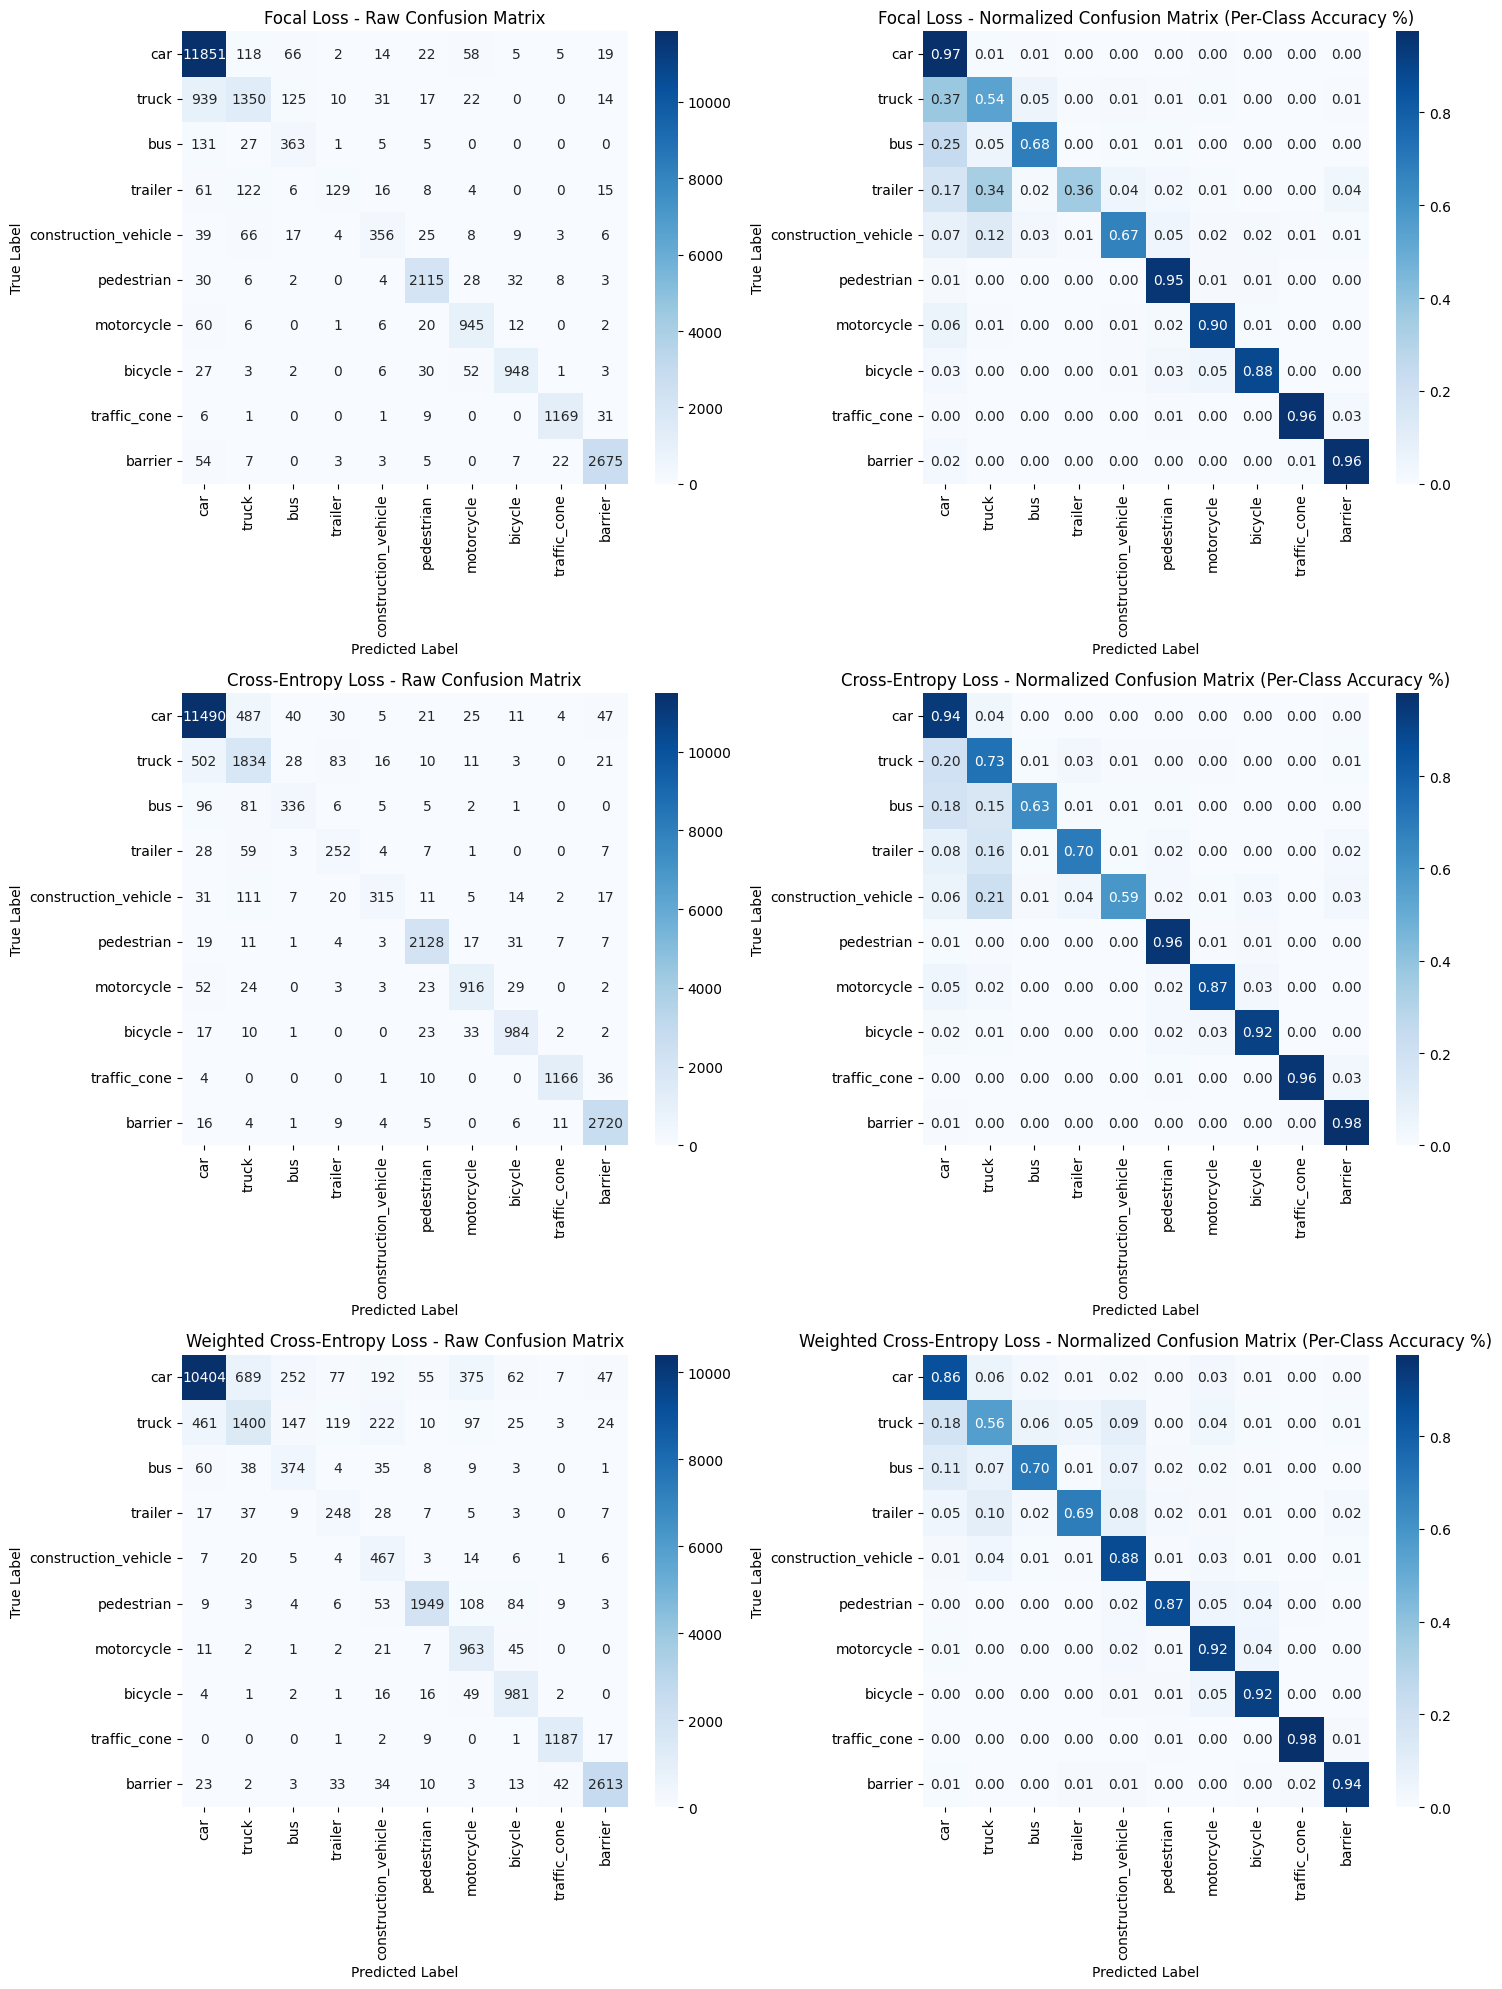

In [22]:
# Plot confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
model_names = ['focal_loss', 'ce_loss', 'weighted_ce_loss']
titles = ['Focal Loss', 'Cross-Entropy Loss', 'Weighted Cross-Entropy Loss']

for idx, loss_name in enumerate(model_names):
    result = results[loss_name]

    # Raw confusion matrix
    cm_raw = confusion_matrix(result['test_targets'], result['test_preds'])
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues',
                xticklabels=[id_to_name[i] for i in range(num_classes)],
                yticklabels=[id_to_name[i] for i in range(num_classes)],
                ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{titles[idx]} - Raw Confusion Matrix')
    axes[idx, 0].set_xlabel('Predicted Label')
    axes[idx, 0].set_ylabel('True Label')

    # Normalized confusion matrix (per-class accuracy %)
    cm_norm = confusion_matrix(result['test_targets'], result['test_preds'], normalize='true')
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[id_to_name[i] for i in range(num_classes)],
                yticklabels=[id_to_name[i] for i in range(num_classes)],
                ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{titles[idx]} - Normalized Confusion Matrix (Per-Class Accuracy %)')
    axes[idx, 1].set_xlabel('Predicted Label')
    axes[idx, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

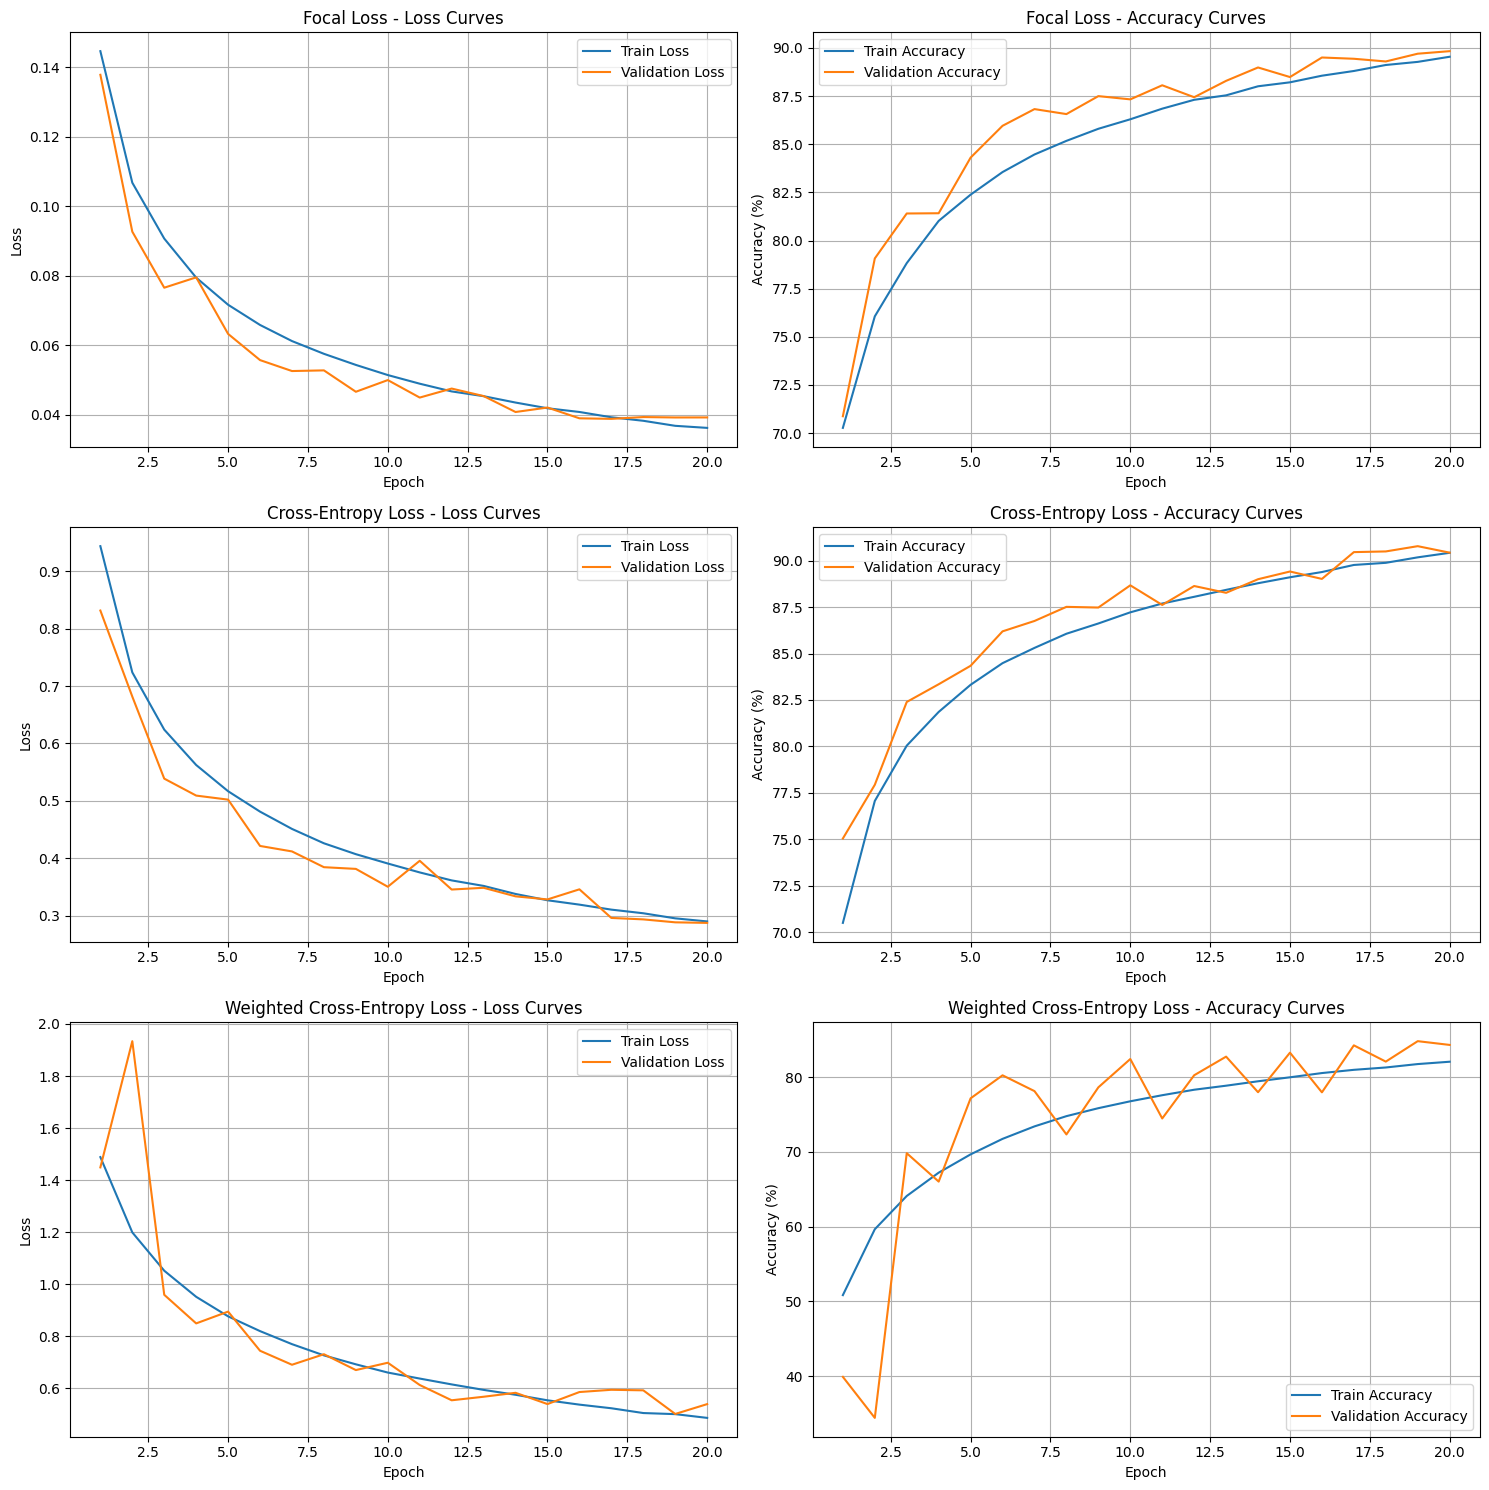

In [24]:
# Plot training curves
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for idx, loss_name in enumerate(model_names):
    result = results[loss_name]

    # Loss curves
    epochs = range(1, len(result['train_losses']) + 1)
    axes[idx, 0].plot(epochs, result['train_losses'], label='Train Loss')
    axes[idx, 0].plot(epochs, result['val_losses'], label='Validation Loss')
    axes[idx, 0].set_title(f'{titles[idx]} - Loss Curves')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True)

    # Accuracy curves
    axes[idx, 1].plot(epochs, result['train_accs'], label='Train Accuracy')
    axes[idx, 1].plot(epochs, result['val_accs'], label='Validation Accuracy')
    axes[idx, 1].set_title(f'{titles[idx]} - Accuracy Curves')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy (%)')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True)

plt.tight_layout()
plt.show()

#GradCam


In [67]:
def overlay_mask(img, mask, alpha=0.5):
    """
    Overlay a colored heatmap on an image
    """
    if isinstance(img, Image.Image):
        img = np.array(img)
    if isinstance(mask, Image.Image):
        mask = np.array(mask)

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = mask.mean(axis=2)

    # Resize mask to match image dimensions
    if mask.shape != (img.shape[0], img.shape[1]):
        from PIL import Image as PILImage
        mask_pil = PILImage.fromarray(mask)
        mask = np.array(mask_pil.resize((img.shape[1], img.shape[0]), resample=PILImage.BILINEAR))

    # Normalize mask to [0, 1]
    mask = (mask - mask.min()) / (mask.max() - mask.min()) if mask.max() != mask.min() else mask

    # Apply colormap (jet) to create colorful heatmap
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap('jet')
    colored_mask = cmap(mask)[:, :, :3]  # Remove alpha channel

    # Convert back to uint8
    colored_mask = (colored_mask * 255).astype(np.uint8)

    # Overlay the colored heatmap on the original image
    overlay = (1 - alpha) * img + alpha * colored_mask
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    return Image.fromarray(overlay)

def run_gradcam_for_model(model, model_name, device, test_loader, id_to_name):
    """
    Run GradCAM visualization for a given model
    """
    # For your SimpleResNet model, the last conv layer is likely in block3
    target_layer_name = "block3.conv2"
    cam_extractor = None

    try:
        try:
            cam_extractor = GradCAM(model, target_layer_name, input_shape=(3, 224, 224))
            print(f"Successfully initialized GradCAM for {model_name} target layer: {target_layer_name}")
        except ValueError as e:
            print(f"Failed to initialize GradCAM for layer '{target_layer_name}': {e}")
            print("Trying fallback layer 'block3'...")
            target_layer_name = "block3"
            try:
                cam_extractor = GradCAM(model, target_layer_name, input_shape=(3, 224, 224))
                print(f"Successfully initialized GradCAM for {model_name} fallback target layer: {target_layer_name}")
            except ValueError as e2:
                print(f"Failed again with fallback layer '{target_layer_name}': {e2}")
                print("Please check the model architecture to identify the correct last conv layer name.")
                # Print model structure to help identify correct layer
                for name, module in model.named_modules():
                    if isinstance(module, torch.nn.Conv2d):
                        print(f"Conv layer: {name}")
                return None

        # Prepare to store 3 images per class
        images_per_class = defaultdict(list)
        max_images_per_class = 3

        # Iterate through the test set to collect images and their GradCAMs
        model.eval()
        found_classes = set()

        for batch_idx, (data, target) in enumerate(test_loader):
            if data is None:
                continue
            data, target = data.to(device), target.to(device)

            # Get predictions
            output = model(data)
            predicted = output.max(1, keepdim=True)[1]

            # Process each item in the batch
            for i in range(data.shape[0]):
                pred_class = predicted[i].item()
                true_class = target[i].item()

                # Only store images if we haven't reached the limit for this class yet
                if len(images_per_class[true_class]) < max_images_per_class:
                    img_tensor = data[i].unsqueeze(0) # Shape: (1, C, H, W)

                    # Get the model output for this specific image
                    out = model(img_tensor)

                    # Compute softmax probabilities
                    probs = F.softmax(out, dim=1).squeeze(0)  # Shape: [10]
                    prob_values = probs.detach().cpu().numpy()
                    predicted_prob = prob_values[pred_class]

                    # Get the GradCAM for the predicted class
                    activation_maps = cam_extractor(class_idx=pred_class, scores=out)

                    # Extract the activation map for the first (and only) image in the batch
                    activation_map_tensor = activation_maps[0]

                    # Handle the activation map tensor shape and type
                    if activation_map_tensor.dim() > 2:
                        activation_map_tensor = activation_map_tensor.squeeze()
                        if activation_map_tensor.dim() > 2:
                            activation_map_tensor = activation_map_tensor.mean(dim=0)
                    elif activation_map_tensor.dim() < 2:
                        print(f"Warning: Activation map tensor has unexpected low dimensions: {activation_map_tensor.dim()}")
                        continue

                    # Ensure the tensor is on CPU and convert to numpy
                    activation_map_np = activation_map_tensor.cpu().numpy()

                    # Normalize the activation map values to [0, 1] for PIL
                    v_min, v_max = activation_map_np.min(), activation_map_np.max()
                    if v_max - v_min != 0:
                        activation_map_np = (activation_map_np - v_min) / (v_max - v_min)
                    else:
                        activation_map_np = np.zeros_like(activation_map_np)

                    # Convert to PIL Image
                    try:
                        cam_pil = Image.fromarray(activation_map_np)
                    except TypeError:
                        activation_map_uint8 = (activation_map_np * 255).astype(np.uint8)
                        cam_pil = Image.fromarray(activation_map_uint8)

                    # Convert tensor image back to a displayable format (un-normalize)
                    # Assuming your images were normalized with ImageNet stats
                    IMAGENET_MEAN = [0.485, 0.456, 0.406]
                    IMAGENET_STD = [0.229, 0.224, 0.225]

                    denorm_transform = transforms.Compose([
                        transforms.Normalize(mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
                                             std=[1/s for s in IMAGENET_STD]),
                        transforms.ToPILImage()
                    ])
                    img_pil = denorm_transform(img_tensor.squeeze(0).cpu())

                    # Overlay the CAM mask on the original image
                    result = overlay_mask(img_pil, cam_pil, alpha=0.5)

                    # Store the original image, the GradCAM result, and the predicted class name
                    images_per_class[true_class].append({
                        'original': img_pil,
                        'gradcam': result,
                        'predicted_name': id_to_name[pred_class],
                        'true_name': id_to_name[true_class],
                        'softmax_probs': prob_values,
                        'predicted_prob': predicted_prob
                    })

                    # Add the class to the found set
                    found_classes.add(true_class)

            # Check if we have collected enough images for all classes
            # Get the total number of unique classes in the dataset
            total_classes = len(id_to_name)
            if len(found_classes) == total_classes and all(len(images) >= max_images_per_class for images in images_per_class.values()):
                print(f"Collected {max_images_per_class} images for all {len(images_per_class)} classes for {model_name}.")
                break

        # Display the collected images - Original and GradCAM side by side
        fig, axes = plt.subplots(max_images_per_class * 2, total_classes, figsize=(20, 12))  # Double rows for original + gradcam

        # Ensure all class IDs from the dataset are represented
        for class_id in sorted(id_to_name.keys()):  # Sort to maintain consistent order
            class_name = id_to_name.get(class_id, f"Class_{class_id}")
            collected_images = images_per_class.get(class_id, [])

            for row_idx in range(max_images_per_class):
                # Show original image (top row for each image)
                orig_ax = axes[row_idx * 2, class_id] if total_classes > 1 else axes[row_idx * 2]
                if row_idx < len(collected_images):
                    img_info = collected_images[row_idx]
                    orig_ax.imshow(img_info['original'])
                    conf = img_info['predicted_prob']
                    orig_ax.set_title(f'{class_name} (Original)\n→ {img_info["predicted_name"]}\n({conf:.2%})', fontsize=8)
                else:
                    orig_ax.text(0.5, 0.5, 'N/A', horizontalalignment='center',
                                verticalalignment='center', transform=orig_ax.transAxes, fontsize=10)
                orig_ax.axis('off')

                # Show GradCAM overlay (bottom row for each image)
                grad_ax = axes[row_idx * 2 + 1, class_id] if total_classes > 1 else axes[row_idx * 2 + 1]
                if row_idx < len(collected_images):
                    img_info = collected_images[row_idx]
                    grad_ax.imshow(img_info['gradcam'])
                    grad_ax.set_title(f'{class_name} (GradCAM)', fontsize=8)
                else:
                    grad_ax.text(0.5, 0.5, 'N/A', horizontalalignment='center',
                                verticalalignment='center', transform=grad_ax.transAxes, fontsize=10)
                grad_ax.axis('off')

        plt.suptitle(f'GradCAM Visualization - {model_name} (Original vs. GradCAM Overlay)', fontsize=16)
        plt.tight_layout()
        plt.show()

    finally:
        # Always clean up GradCAM hooks, even if there was an error
        if cam_extractor is not None:
            try:
                cam_extractor.remove_hooks()
                print(f"Grad-CAM hooks successfully removed for {model_name}.")
            except Exception as e:
                print(f"Warning: Failed to remove Grad-CAM hooks for {model_name}: {e}")

    return images_per_class

Loading Focal Loss model...
Focal Loss model loaded successfully!
Loading Cross Entropy model...
Cross Entropy model loaded successfully!
Loading Weighted Cross Entropy model...
Weighted Cross Entropy model loaded successfully!

Running GradCAM for Focal Loss Model
Successfully initialized GradCAM for Focal Loss target layer: block3.conv2
Collected 3 images for all 10 classes for Focal Loss.


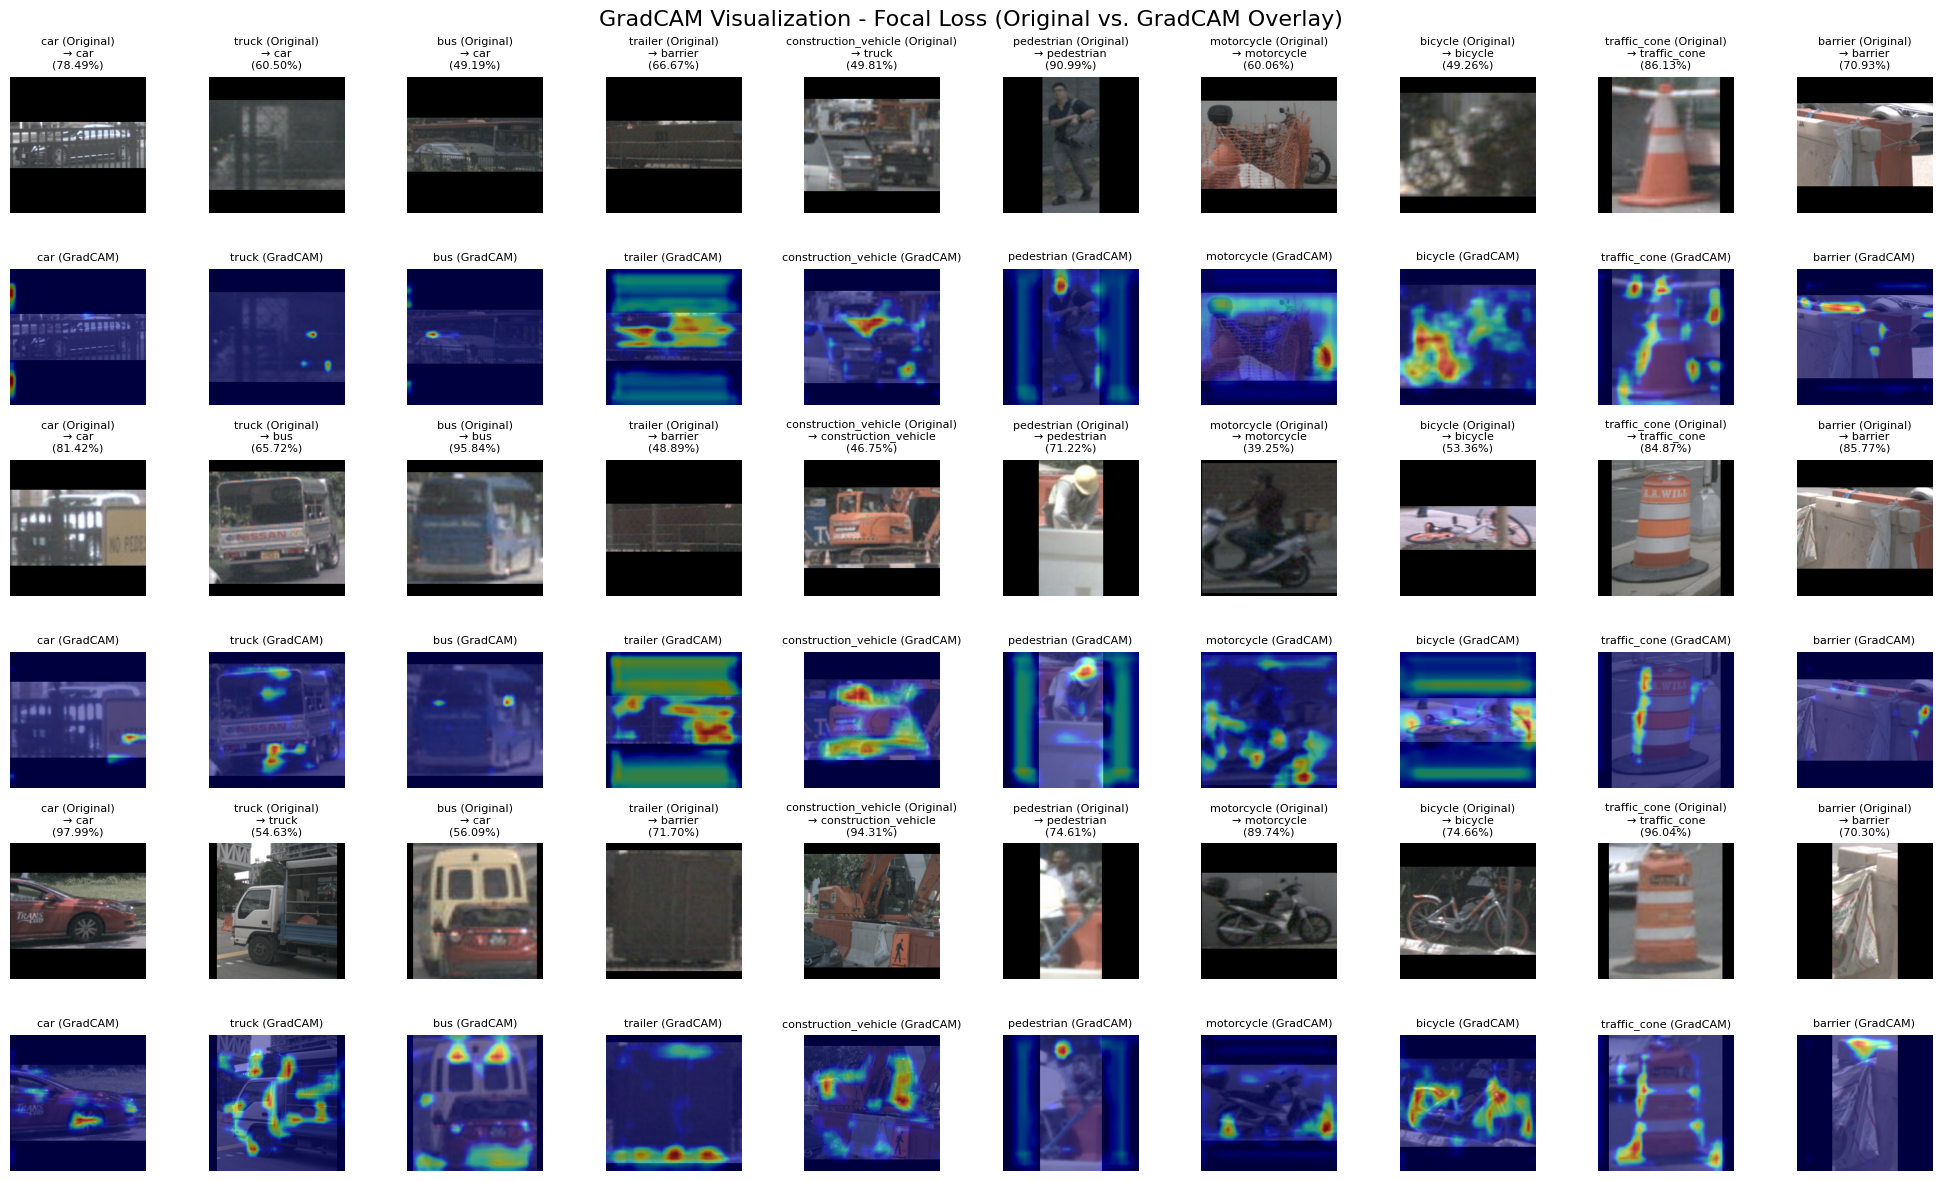

Grad-CAM hooks successfully removed for Focal Loss.

Running GradCAM for Cross Entropy Model
Successfully initialized GradCAM for Cross Entropy target layer: block3.conv2
Collected 3 images for all 10 classes for Cross Entropy.


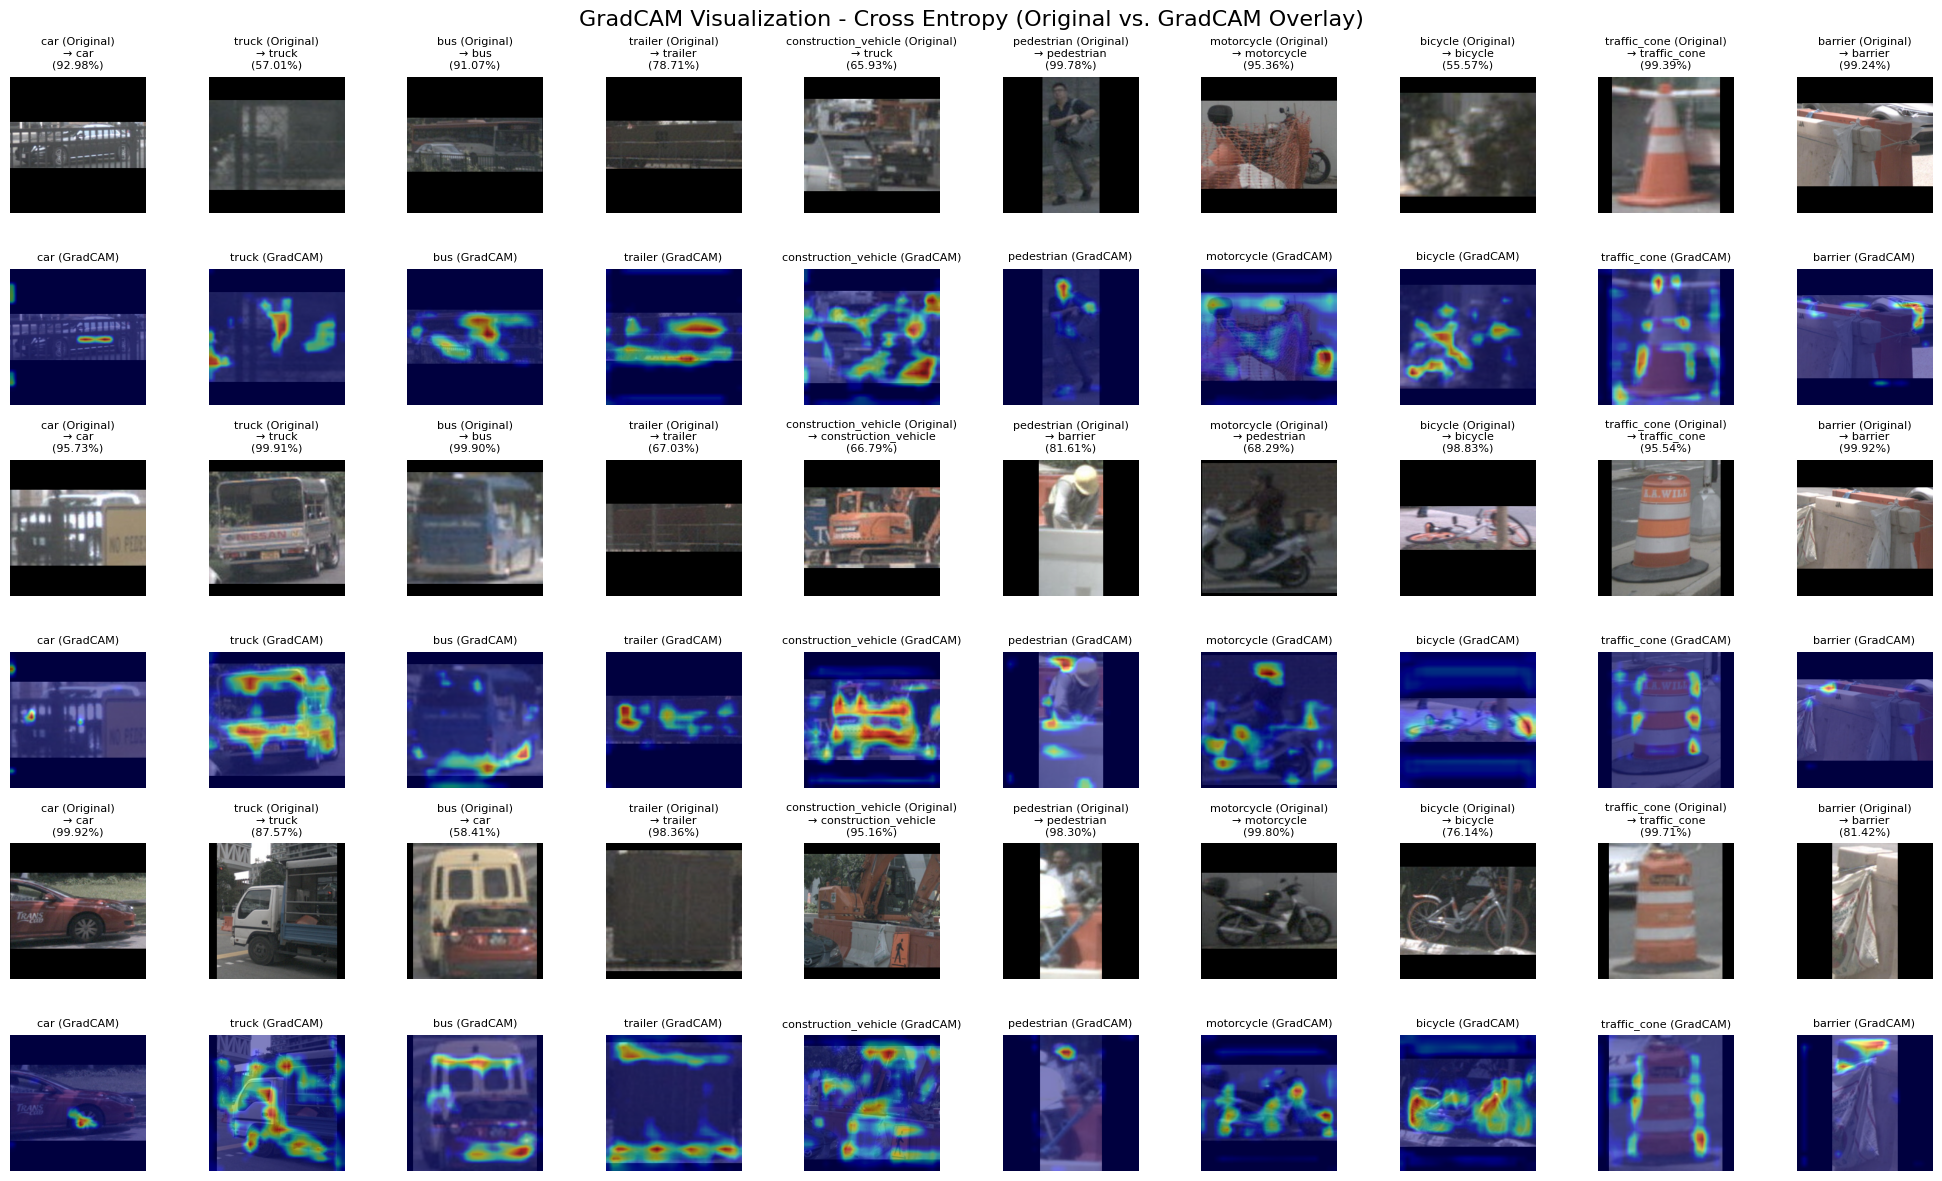

Grad-CAM hooks successfully removed for Cross Entropy.

Running GradCAM for Weighted Cross Entropy Model
Successfully initialized GradCAM for Weighted Cross Entropy target layer: block3.conv2
Collected 3 images for all 10 classes for Weighted Cross Entropy.


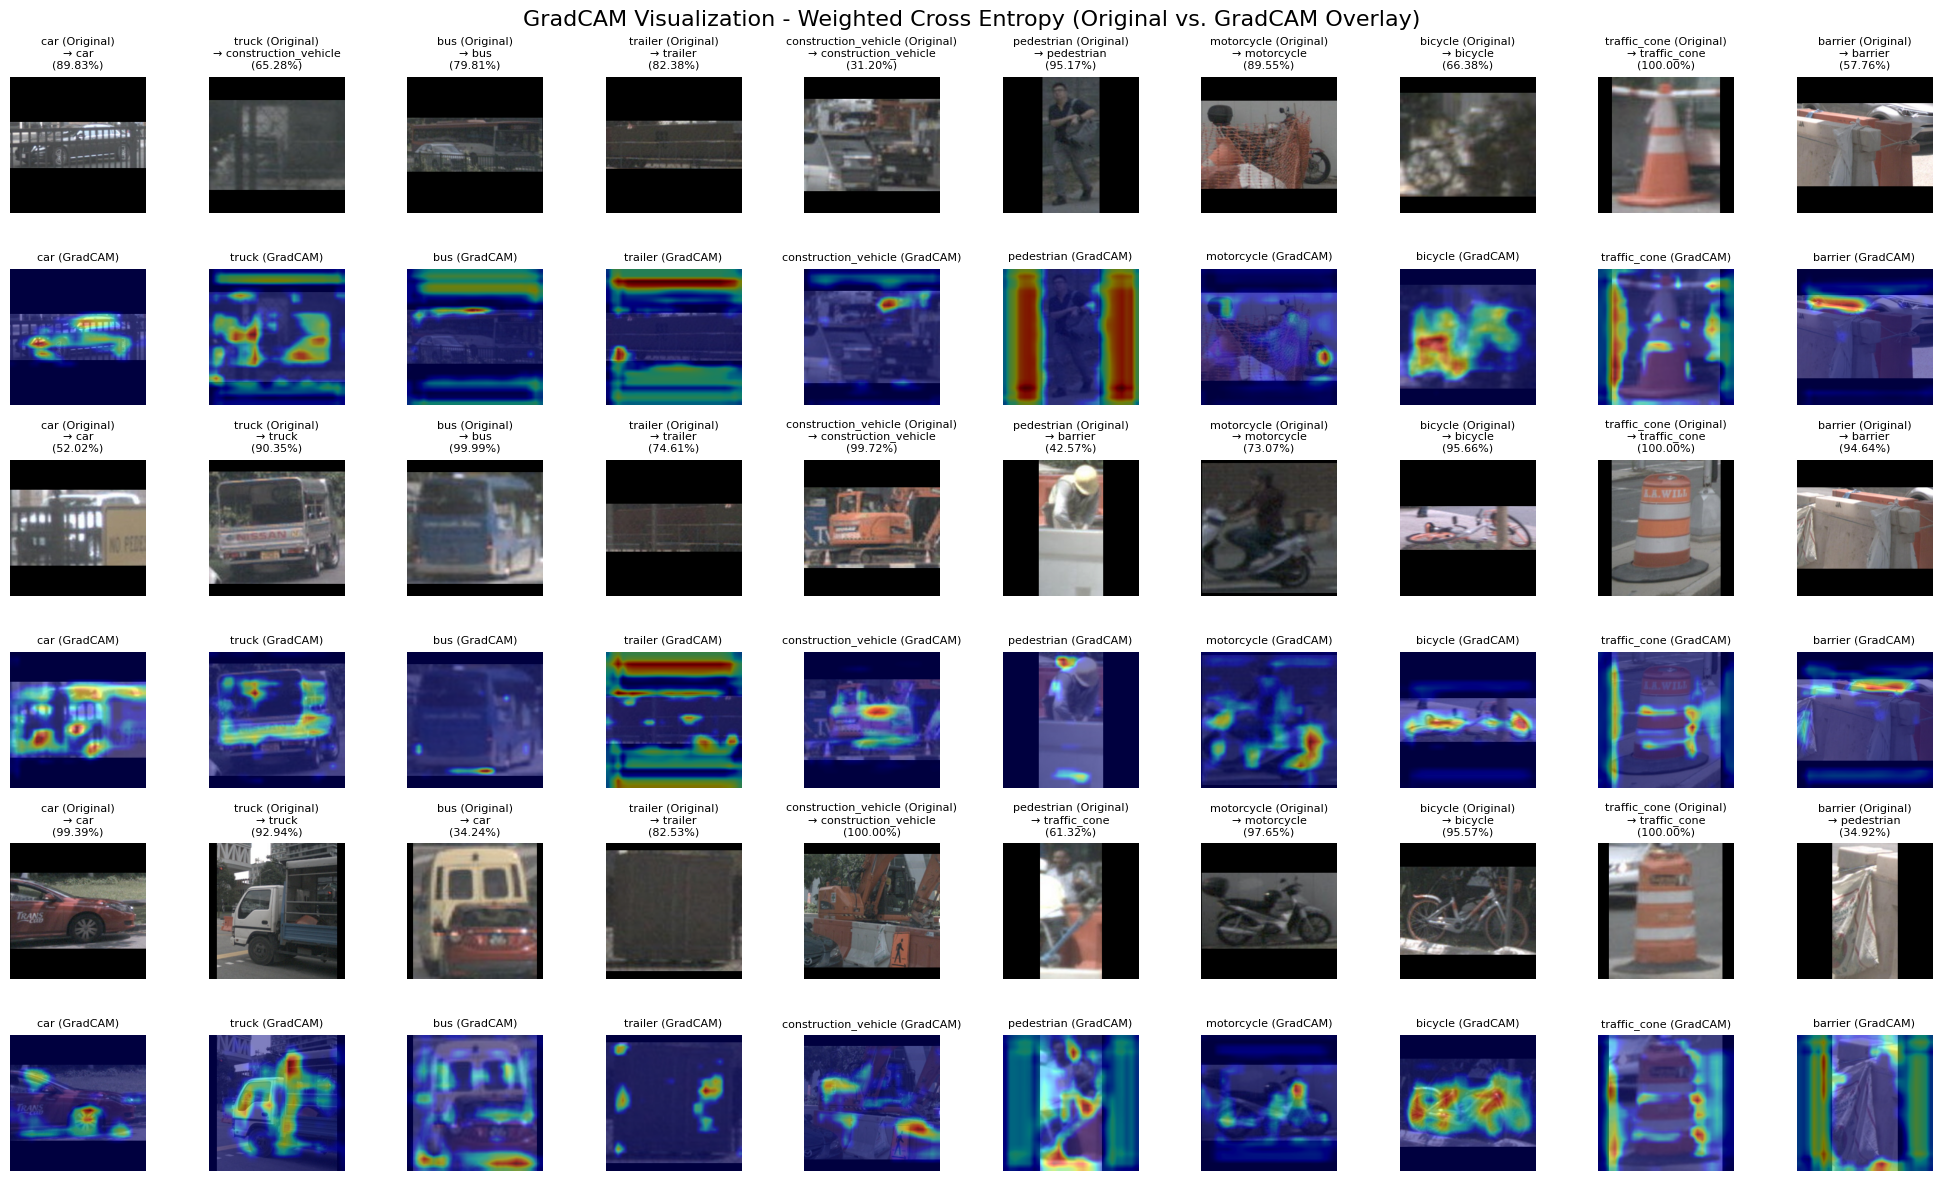

Grad-CAM hooks successfully removed for Weighted Cross Entropy.

All GradCAM visualizations completed!


In [68]:
# Create model instances
def create_model():
    model = SimpleResNet(num_classes=len(id_to_name))
    return model

# Load Focal Loss model
print("Loading Focal Loss model...")
focal_model = create_model()
focal_checkpoint = torch.load("models/best_model_focal_loss.pth", map_location=device)
if 'model_state_dict' in focal_checkpoint:
    focal_model.load_state_dict(focal_checkpoint['model_state_dict'])
else:
    focal_model.load_state_dict(focal_checkpoint)
focal_model = focal_model.to(device)
print("Focal Loss model loaded successfully!")

# Load Cross Entropy model
print("Loading Cross Entropy model...")
ce_model = create_model()
ce_checkpoint = torch.load("models/best_model_cross_entropy.pth", map_location=device)
if 'model_state_dict' in ce_checkpoint:
    ce_model.load_state_dict(ce_checkpoint['model_state_dict'])
else:
    ce_model.load_state_dict(ce_checkpoint)
ce_model = ce_model.to(device)
print("Cross Entropy model loaded successfully!")

# Load Weighted Cross Entropy model
print("Loading Weighted Cross Entropy model...")
wce_model = create_model()
wce_checkpoint = torch.load("models/best_model_weighted_cross_entropy.pth", map_location=device)
if 'model_state_dict' in wce_checkpoint:
    wce_model.load_state_dict(wce_checkpoint['model_state_dict'])
else:
    wce_model.load_state_dict(wce_checkpoint)
wce_model = wce_model.to(device)
print("Weighted Cross Entropy model loaded successfully!")

# Assuming you have your test_loader defined somewhere in your code
# test_loader = your_test_loader

# Run GradCAM for each model
print("\n" + "="*50)
print("Running GradCAM for Focal Loss Model")
print("="*50)
focal_results = run_gradcam_for_model(focal_model, "Focal Loss", device, test_loader, id_to_name)

print("\n" + "="*50)
print("Running GradCAM for Cross Entropy Model")
print("="*50)
ce_results = run_gradcam_for_model(ce_model, "Cross Entropy", device, test_loader, id_to_name)

print("\n" + "="*50)
print("Running GradCAM for Weighted Cross Entropy Model")
print("="*50)
wce_results = run_gradcam_for_model(wce_model, "Weighted Cross Entropy", device, test_loader, id_to_name)

print("\nAll GradCAM visualizations completed!")

#TSNE Feature Space

In [56]:
def extract_features(model, dataloader, device='cuda'):
    """Extract features from the model before the final classifier layer"""
    model.eval()  # Set to evaluation mode

    features = []
    labels = []

    # Disable gradients for the entire model
    for param in model.parameters():
        param.requires_grad = False

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (data, target) in enumerate(dataloader):
            if data is None:
                continue
            data = data.to(device)
            target = target.to(device)

            # Forward pass until the global average pooling layer
            x = model.initial_conv(data)
            x = model.initial_bn(x)
            x = model.initial_relu(x)
            x = model.maxpool(x)

            x = model.block1(x)
            x = model.block2(x)
            x = model.block3(x)

            # Global average pooling
            x = model.global_avg_pool(x)
            x = x.view(x.size(0), -1)  # This gives us the 256-dim feature vector

            features.append(x.cpu().numpy())
            labels.extend(target.cpu().numpy())

    # Re-enable gradients if needed (though not necessary since we're just extracting features)
    for param in model.parameters():
        param.requires_grad = True

    features = np.vstack(features)
    labels = np.array(labels)

    return features, labels




In [59]:
# Reload Focal Loss model
print("Reloading Focal Loss model...")
focal_model_clean = create_model()
focal_checkpoint = torch.load("models/best_model_focal_loss.pth", map_location=device)
if 'model_state_dict' in focal_checkpoint:
    focal_model_clean.load_state_dict(focal_checkpoint['model_state_dict'])
else:
    focal_model_clean.load_state_dict(focal_checkpoint)
focal_model_clean = focal_model_clean.to(device)
print("Focal Loss model reloaded successfully!")

# Reload Cross Entropy model
print("Reloading Cross Entropy model...")
ce_model_clean = create_model()
ce_checkpoint = torch.load("models/best_model_cross_entropy.pth", map_location=device)
if 'model_state_dict' in ce_checkpoint:
    ce_model_clean.load_state_dict(ce_checkpoint['model_state_dict'])
else:
    ce_model_clean.load_state_dict(ce_checkpoint)
ce_model_clean = ce_model_clean.to(device)
print("Cross Entropy model reloaded successfully!")

# Reload Weighted Cross Entropy model
print("Reloading Weighted Cross Entropy model...")
wce_model_clean = create_model()
wce_checkpoint = torch.load("models/best_model_weighted_cross_entropy.pth", map_location=device)
if 'model_state_dict' in wce_checkpoint:
    wce_model_clean.load_state_dict(wce_checkpoint['model_state_dict'])
else:
    wce_model_clean.load_state_dict(wce_checkpoint)
wce_model_clean = wce_model_clean.to(device)
print("Weighted Cross Entropy model reloaded successfully!")

# Now update the results dictionary with the clean models
results['focal_loss']['model'] = focal_model_clean
results['ce_loss']['model'] = ce_model_clean
results['weighted_ce_loss']['model'] = wce_model_clean

# Extract features for each model
tsne_results = {}
for loss_name, result in results.items():
    print(f"\nExtracting features for {loss_name.upper()} model...")
    model = result['model']

    # Extract features from validation set (or a subset of test set if validation is preferred)
    features, true_labels = extract_features(model, val_loader, device=device)

    # Apply t-SNE
    print(f"Applying t-SNE to {features.shape[0]} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_features = tsne.fit_transform(features)

    tsne_results[loss_name] = {
        'tsne_features': tsne_features,
        'true_labels': true_labels
    }



Reloading Focal Loss model...
Focal Loss model reloaded successfully!
Reloading Cross Entropy model...
Cross Entropy model reloaded successfully!
Reloading Weighted Cross Entropy model...
Weighted Cross Entropy model reloaded successfully!

Extracting features for FOCAL_LOSS model...
Applying t-SNE to 24335 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Extracting features for CE_LOSS model...
Applying t-SNE to 24335 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Extracting features for WEIGHTED_CE_LOSS model...
Applying t-SNE to 24335 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


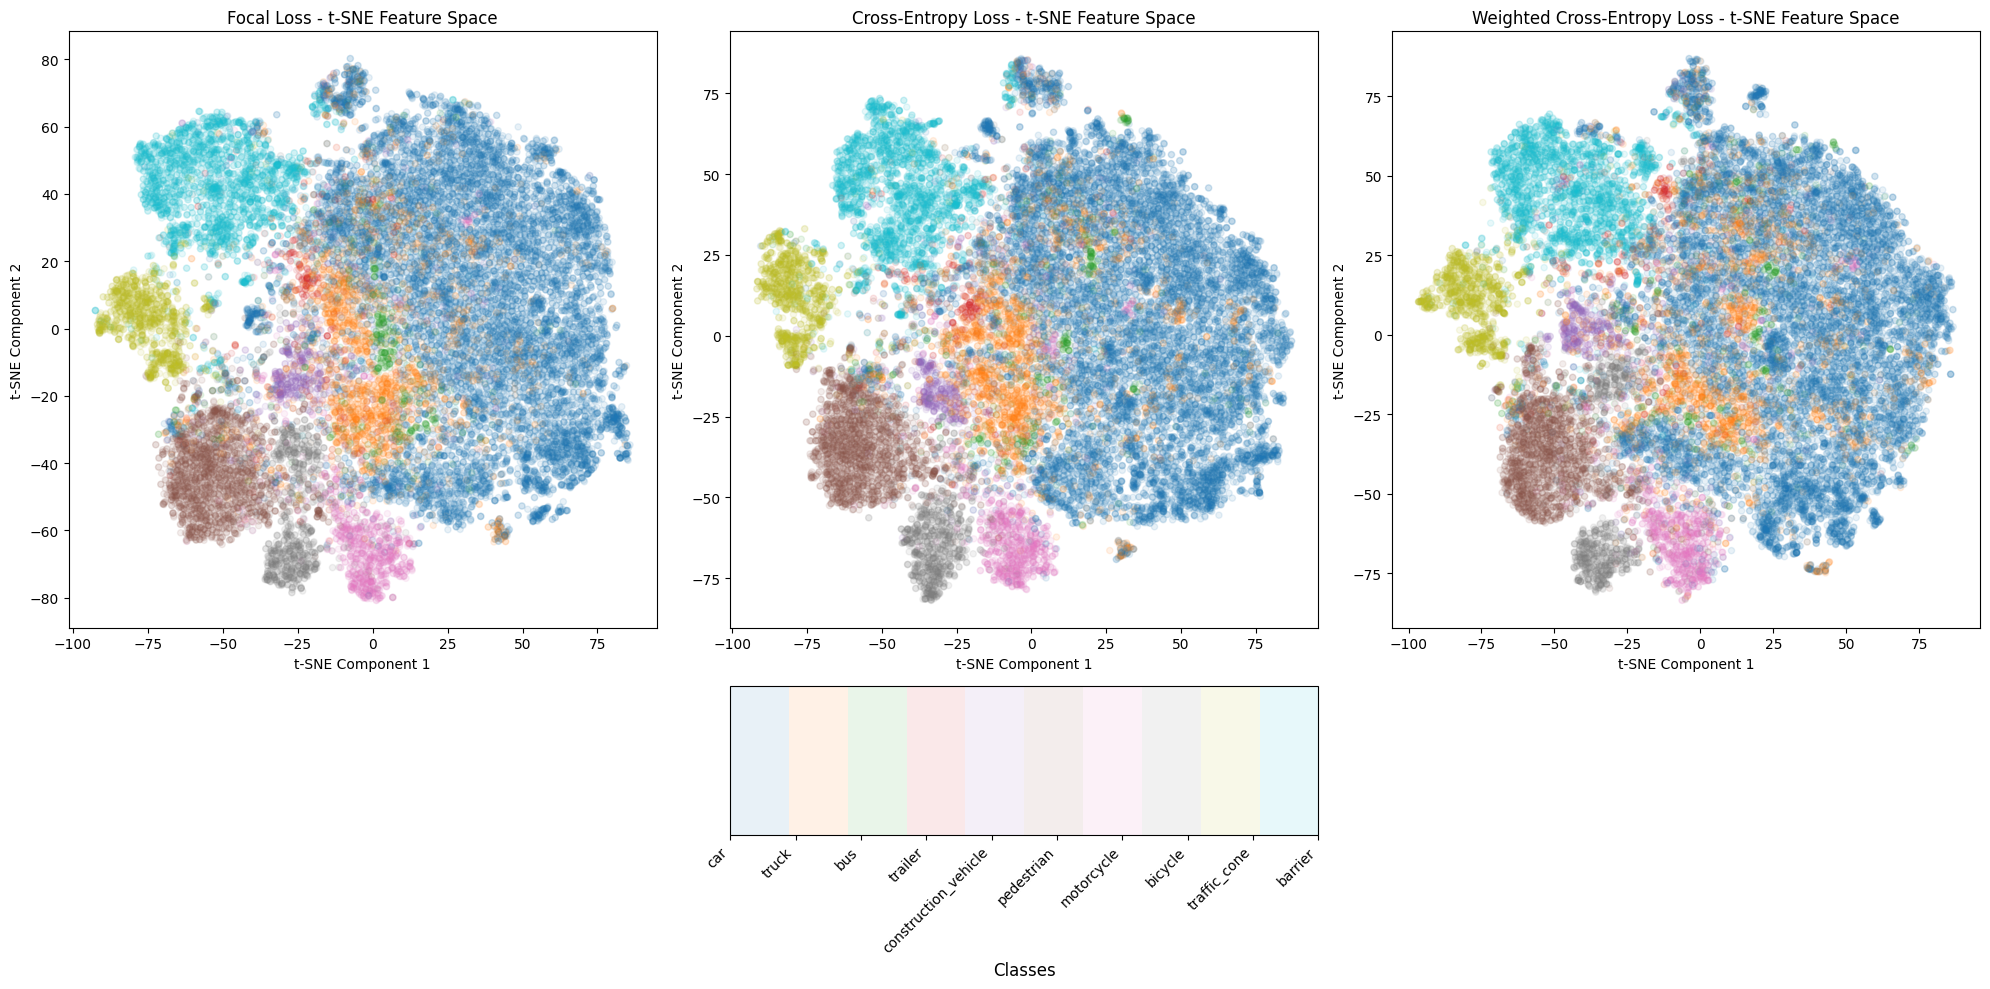

In [66]:
# Plot t-SNE results with a single colorbar below all plots
fig, axes = plt.subplots(2, 3, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})
model_names = ['focal_loss', 'ce_loss', 'weighted_ce_loss']
titles = ['Focal Loss', 'Cross-Entropy Loss', 'Weighted Cross-Entropy Loss']

# Create a common color mapping across all plots
all_true_labels = np.concatenate([tsne_results[loss_name]['true_labels'] for loss_name in model_names])
vmin, vmax = all_true_labels.min(), all_true_labels.max()

for idx, loss_name in enumerate(model_names):
    tsne_data = tsne_results[loss_name]
    tsne_features = tsne_data['tsne_features']
    true_labels = tsne_data['true_labels']

    scatter = axes[0, idx].scatter(tsne_features[:, 0], tsne_features[:, 1],
                                  c=true_labels, cmap='tab10', alpha=0.1, s=20,
                                  vmin=vmin, vmax=vmax)  # Use common color range
    axes[0, idx].set_title(f'{titles[idx]} - t-SNE Feature Space')
    axes[0, idx].set_xlabel('t-SNE Component 1')
    axes[0, idx].set_ylabel('t-SNE Component 2')

# Add a single colorbar below all plots
cbar_ax = axes[1, 1]  # Use the middle bottom subplot for the colorbar
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', alpha=1)
cbar.set_label('Classes', fontsize=12, alpha=1)

# Set custom tick labels using the class names from JSON
cbar_ticks = sorted(id_to_name.keys())  # Get all class IDs in order
class_names = [id_to_name[i] for i in cbar_ticks]

# Set ticks and labels
cbar.set_ticks(cbar_ticks)
cbar.ax.set_xticklabels(class_names, rotation=45 if len(class_names) > 5 else 0,
                       ha='right' if len(class_names) > 5 else 'center', fontsize=10)

# Hide the other bottom subplots
axes[1, 0].set_visible(False)
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()